<a href="https://colab.research.google.com/github/Huertas97/GenAI-FashionMNIST/blob/main/notebooks/AHG_GenAI_FashionMNIST_Conditional_UNet_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenAI FashionMNIST Challenge



*   Author: Álvaro Huertas García
*   Contact:
  * GitHub: [Huertas97](https://github.com/Huertas97)
  * Gmail: ahuertasg01@gmail.com



Reference List of Sources used:

- https://wandb.ai/capecape/train_sd/reports/How-to-Train-a-Conditional-Diffusion-Model-from-Scratch--VmlldzoyNzIzNTQ1

- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb

- https://github.com/zalandoresearch/fashion-mnist

- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/


- (strongly recommended for a gently but complete  introduction learning)
  - https://jalammar.github.io/illustrated-stable-diffusion/
  - https://huggingface.co/blog/annotated-diffusion

## Outline

- Overview
- Setup
- FashionMNIST Dataset Analysis

## Overview

In this Notebook I am going to:
*  explore the FashionMNIST dataset
*  create **from scratch** and train a class-conditioned UNet model using Pytorch and Diffuser library from HuggingFace
* Evaluate the model using MSE loss
* Test the conditioned generation capabilities of the model

### **What is UNet?**

Something to make clear is the distintion of UNet model, and diffusion process.

UNet is a deep neural network model that was originally introduced in the computer vision field initially for image segmentation, specifically biomedical images ([Paper Link](https://arxiv.org/abs/1505.04597)).

The architecture of UNet conssits of a symmetric architecture with convolutional and pooling layers for downsampling, and then upsampling the image, with skip connections between the symmetric layers. In other words, UNet is an image autoencoder.

On the other hand, Diffusion, that are commonly find in the literatue as "Diffusion models", englobe models that gradually add noise to the original data in the forward diffusion process and then learning to remove the noise in the reverse diffusion process, also named denoising.

UNet can belong to the "diffusion models" category as it can be trained using the diffusion approach to exploit the latent variable extraction autoencoder capabilities of UNet architecture to predict noise of a image, and iteratively remove it to obtain after certain number of step a denoised generated image.
<br>

### **What is a conditional UNet model?**

Solely UNet model are unconditioned models as they do not include any other information during the training/inference phase, as they just provide the expected noise of an image that can be removed form an original noisy image untill finally obtaining the generated image. So this process lacks of guidance or control just relying on the input noisy image.

However, Conditional UNet is a variant of the UNet model that incorporates additional conditional information into the network, so we can explit the capability of adding information during the denoising process where we expect the model to learn how to predict noise to be removed conditioned to the information passed alongside an input image.

In our case, the information will be the class label of the FashionMNIST. Thus, the Conditonal UNet model can be controlled to create a image of an specified class.



Btw: If our scenario required conditioning the output image, with an image instead of the class label, we could have use ControlNet.

Once we have a bit background and organized our ideas, let's jupm to the fun part of coding.


## Notebook Setup

In [1]:
%pip install -qq diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.7 MB/s eta 0:00:00


In [2]:
%pip install -qq icecream torch-summary  accelerate livelossplot wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.9 MB/s eta 0:00:00


In [3]:
import diffusers
print(diffusers.__version__)

0.29.2


In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from icecream import ic
ic.configureOutput(prefix='DEBUG -> ') # helpful for debugging instead of print
import torchsummary
from livelossplot import PlotLosses
import math
import wandb
import os


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## FashionMNIST Dataset Analysis


FashionMNIST consists of clothes images assigned to one of the following labels ([GitHub Link](https://github.com/zalandoresearch/fashion-mnist)):

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [2]:


# Load the dataset
dataset = torchvision.datasets.FashionMNIST(root="fashionmnist/",
                                            train=True,  # download the train split
                                            download=True,
                                            transform=torchvision.transforms.ToTensor())


# Show info about dataset
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionmnist/
    Split: Train
    StandardTransform
Transform: ToTensor()

### EDA

In [ ]:
# Create a exploratory dataloader (batch size 8 for showing 8 images)
eda_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Class names for FashionMNIST
class_labels_names = ["T-shirt/top", "Trouser", "Pullover",
                "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
                "Bag", "Ankle boot"]

# Loop through the dataset, collect: image n channels, height and witdh, labels
labels = []
image_sizes = []
image_n_channels = []
color_distributions = []
for image, label in tqdm(dataset, desc="Loading labels and extracting images"):
    # RGB channels
    image_n_channels.append(image.shape[0])

    # Resolution
    image_sizes.append((image.shape[1], image.shape[2]))

    # Labels
    labels.append(label)

    # Color distribution scaled of the image
    pixel_values = (image * 255).flatten().numpy().astype(int)
    color_distribution = np.bincount(pixel_values, minlength=256)
    color_distributions.append(color_distribution)

## Version with comprehension list
# dataset_info = [(image.shape[0], (image.shape[1], image.shape[2]), label) for image, label in
#                 tqdm(dataset, desc="Dataset looping")]
# image_n_channels, image_sizes, labels = zip(*dataset_info)

print(f"Distribution of number of RGB Channels: {Counter(image_n_channels)}")
print(f"Distribution of Resolution (image size in px): {Counter(image_sizes)}")
print(f"Distribution of labels: {Counter(labels)}\n")

Loading labels and extracting images:   0%|          | 0/60000 [00:00<?, ?it/s]

Distribution of number of RGB Channels: Counter({1: 60000})
Distribution of Resolution (image size in px): Counter({(28, 28): 60000})
Distribution of labels: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})



* We have a dataset of 60,000 images, each with a resolution of 28x28px and a single RGB channel.

* The images are divided into 10 classes, with each class represented uniformily by 6k instances.

For the sake of showing some visualization, even thogh we have gathered the most important details about the dataset, we are going to proceed with some visualization that could be useful for other complex datasets.

#### Visualize images in the dataset with the labels

Here we will see the size (pixels), and the RGB channels of the images.

Image input shape: torch.Size([8, 1, 28, 28])
Labels: [3 0 8 1 0 0 0 2]


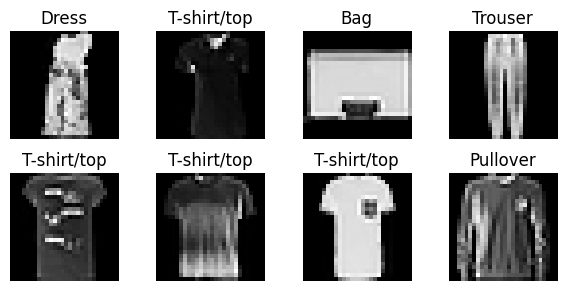

In [ ]:
# Get examples from the dataloader
x, y = next(iter(eda_dataloader))
print('Image input shape:', x.shape) # [batch, RGB channels, height, witdh]
print('Labels:', y.detach().numpy())

# Create a grid of images with their labels
fig, axs = plt.subplots(2, 4, figsize=(6, 3))
for i, (img, label) in enumerate(zip(x, y)):
    ax = axs[i // 4, i % 4]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(class_labels_names[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Plotting Histogram of Image Sizes

Here we check visually all the images have the same size (28x28px = 784 px).

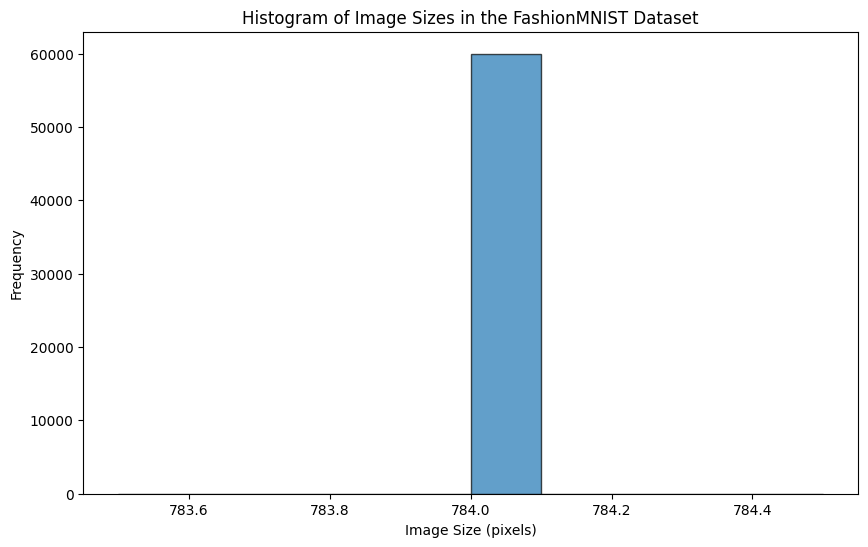

In [ ]:
# Extract image sizes (all 28x28 for FashionMNIST)
image_sizes = [image.shape[1] * image.shape[2] for image, _ in dataset]

# Plotting histogram of image sizes
plt.figure(figsize=(10, 6))
plt.hist(image_sizes, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Image Size (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Image Sizes in the FashionMNIST Dataset')
plt.show()

#### Visualizing the Distribution of Images

Visually checking that there is no imbalance, as all classes have 6.000 data instances.

The imbalanced distribution can affect on how the conditional UNet model struggle to generate some classes intead of another.

In case it was imbalanced, we would need to consider some techcniques for helping the model to equitative learn across all the classes (e.g. oversampling, undersampling, weighted loss).

In [ ]:
# Visualize the distribution of images in the dataset

# Prepare the x (class names) and y (frequency) data to plot
labels_sorted, freq = zip(*(Counter(labels)).items()) # sorted by Counter
class_labels_sorted = [class_labels[i] for i in labels_sorted] # from int to class name

# Plotly figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_labels_sorted,
    y=freq,
    marker_color='royalblue'
))

fig.update_layout(
    title='Distribution of Images in the FashionMNIST Dataset',
    xaxis_title='Class',
    yaxis_title='Frequency'
)

fig.show() # in GitHub it will not be displayed

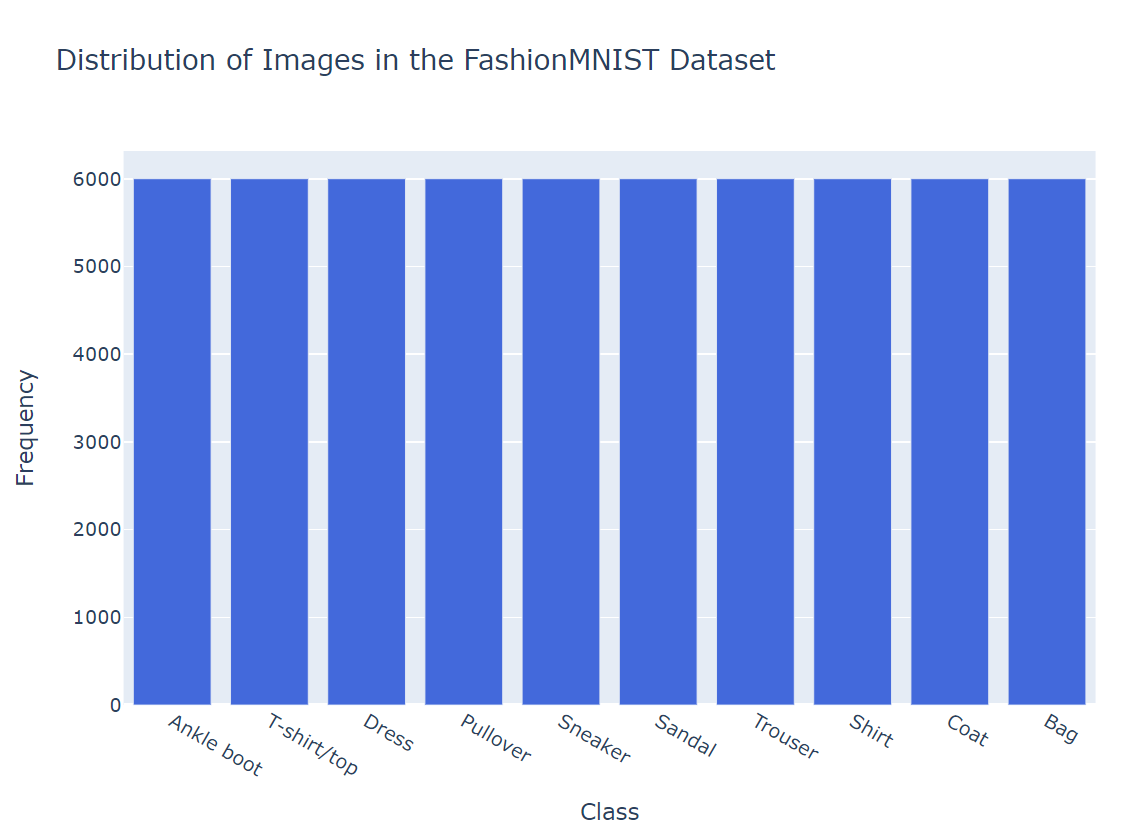

#### Scatter Plot of Image Resolutions

We already know that all images are 28x28 px. However with this code we would make a scatterplot to check it visually.

Honestly, it would be most usefull in a more complex dataset where images have different sizes. Then, we would know how to sclae them to mantain an uniform size across all the dataset to be fed into the model.

In [ ]:
import plotly.express as px

# Create a scatter plot for image resolutions
fig = px.scatter(x=np.array(image_sizes)[:, 0], y=np.array(image_sizes)[:, 0],
                 labels={'x': 'Width (pixels)', 'y': 'Height (pixels)'},
                 title='Scatter Plot of Image Resolutions in the FashionMNIST Dataset')

fig.show()

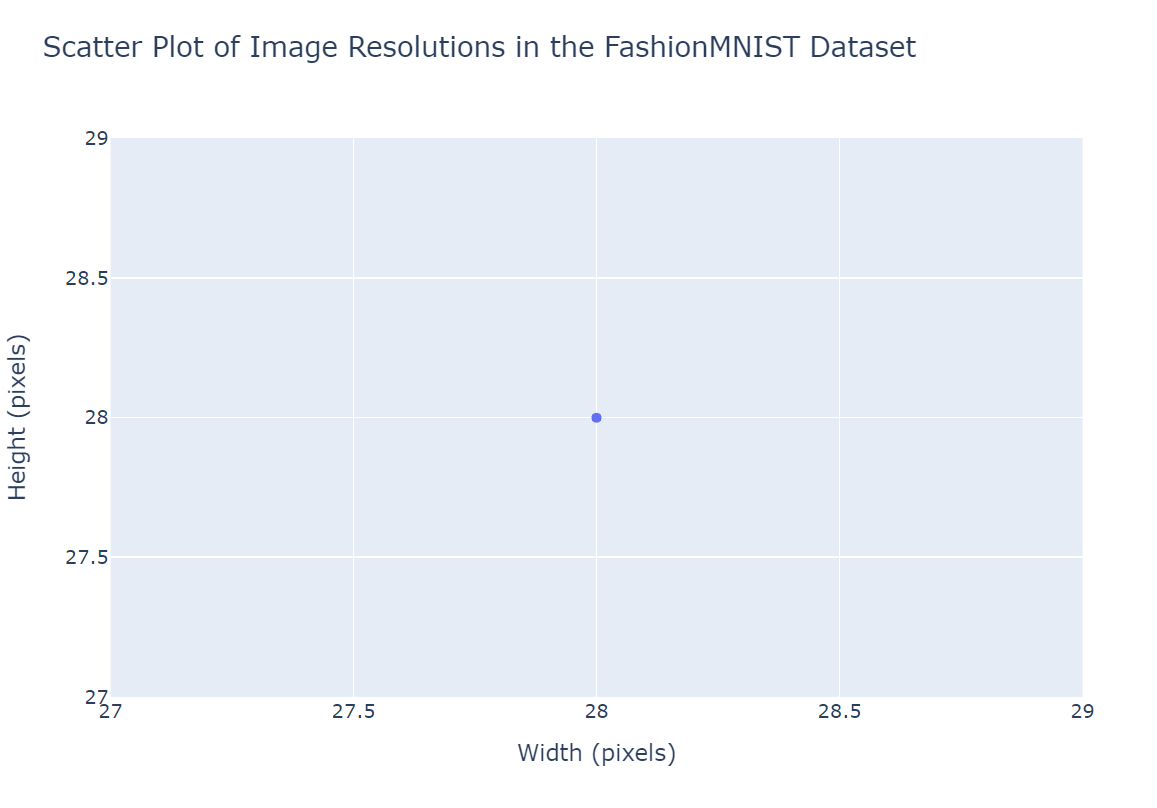

#### Mean Color Distribution

In [ ]:
# Mean color distribution of the images of the dataset
fig = px.bar(x=np.arange(256), y=np.mean(color_distributions, axis=0),
             labels={'x': 'Pixel Intensity', 'y': 'Frequency'},
             title='Mean Color Distribution of the Dataset (one RGB channel)')

fig.show()

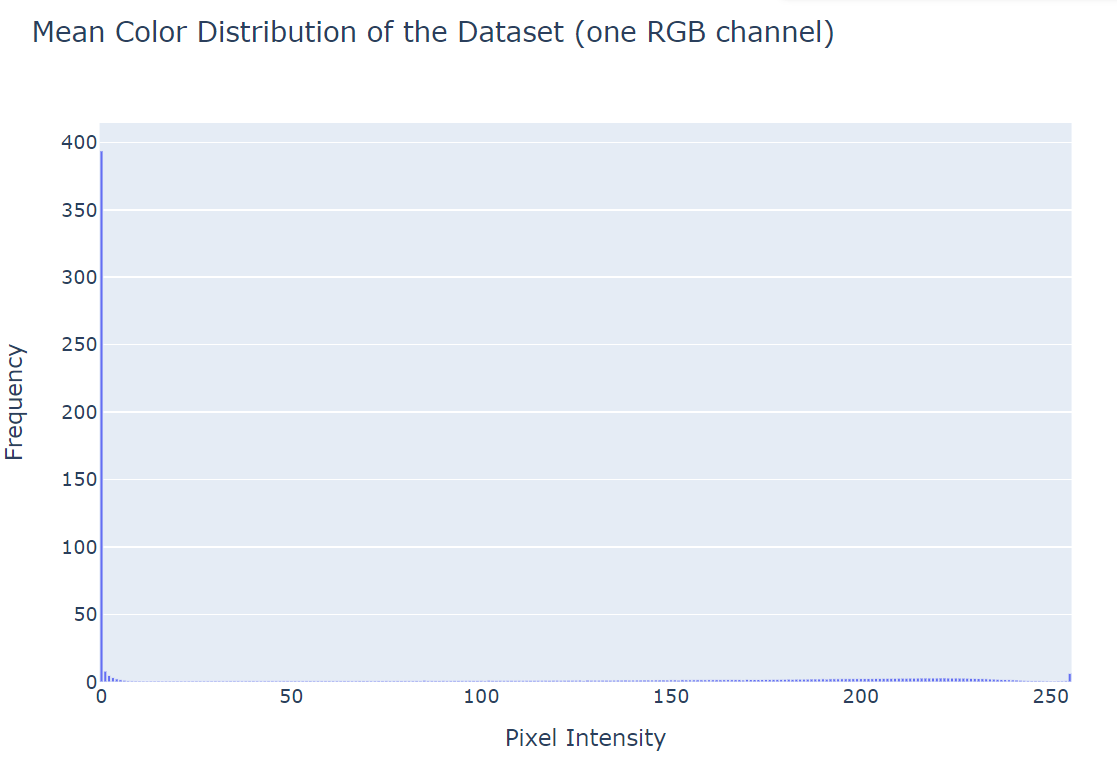

## UNet Implementation (conditional UNet)

Clearly, this code is inspired by the HuggingFace Diffusers course [link](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb#scrollTo=C4YOLrfs2cTF).

However, I explain some details and things to consider about the model architecture.


* First, I will use three residual connections (ResNet) in each UNet block (paramter `layers_per_block`) instead of just one, trusting the good practices and recommendations of the literature that indicates this configuration intends to address the potential overfitting from the model's complexity and improve how the gradient flow [paper](https://arxiv.org/abs/2312.09608). Based on this, I selected 3 Resnet following the Improved DDPM [paper](https://arxiv.org/pdf/2102.09672).

* Secondly, `AttnDownBlock2D` and `AttnUpBlock2D` blocks apply self-attention mechanism for a better spatial information learning. In the downsampling, the initial layers have "poor" information extracted in the features as these are the initial layers, and as we move deeper in the UNet model we extract more information. So, applying attention mechanism enhance the extracted information in this downsampling encoding process. In the upsampling process, attention enhance spatial information but working at the the resiudal connection's (skip connections) level. Attention applied to the skip connection allows the model to learn by focusing more on the important spatial information and suppressing activations at irrelevant regions. Nevertheless, full self-attention is quadratic so it has memory limitations.  


* In the Improved DDPM [paper](https://arxiv.org/pdf/2102.09672) they use 0.3 dropout value for the cosine noise scheduler (more about that in the next section). So we add  


In [3]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels
    # to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # output image resolution. Equal to input resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond
        out_channels=1,           # the number of output channels. Equal to input
        layers_per_block=3,       # three residual connections (ResNet) per block
        block_out_channels=(224, 448, 672), # N of output channels for each block. Inverse for upsampling
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        ),
        up_block_types=(
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "AttnUpBlock2D",
            "UpBlock2D",  # a regular ResNet upsampling block
        ),
        dropout = 0.1,  # Dropout prob between Conv1 and Conv2 in a block. From Improved DDPM paper
    )

  # Forward method takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape # x is shape (bs, 1, 28, 28)

    # class conditioning embedding to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # class_cond final shape (bs, 4, 28, 28)

    # Model input is now x and class cond concatenated together along dimension 1
    # We need provide additional information (the class label)
    # to every spatial location (pixel) in the image. Not changing the original
    # pixels of the images, but adding new channels.
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    # with image output size
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [7]:
model = ClassConditionedUnet()

# Dummy input for forward pass for torchsummary to estimate size
x = torch.randn(1, 1, 28, 28)     # Dummy input for image
t = torch.tensor([0.5])           # Dummy timestep
class_labels = torch.tensor([0])  # Dummy class label
dummy_input = (x, t, class_labels)


# model summary (condensed view)
_ = torchsummary.summary(model,
                        #  input_data=dummy_input,
                         device=device)

# model summary (expanded view with forward pass)
print(f"\n\n{'-'*50} \n\n")
_ = torchsummary.summary(model,
                         input_data=dummy_input,
                         device=device)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         40
├─UNet2DModel: 1-2                       --
|    └─Conv2d: 2-1                       10,304
|    └─Timesteps: 2-2                    --
|    └─TimestepEmbedding: 2-3            --
|    |    └─Linear: 3-1                  201,600
|    |    └─SiLU: 3-2                    --
|    |    └─Linear: 3-3                  803,712
|    └─ModuleList: 2-4                   --
|    |    └─DownBlock2D: 3-4             3,768,128
|    |    └─AttnDownBlock2D: 3-5         15,472,128
|    |    └─AttnDownBlock2D: 3-6         30,583,616
|    └─ModuleList: 2-5                   --
|    |    └─AttnUpBlock2D: 3-7           64,619,744
|    |    └─AttnUpBlock2D: 3-8           29,934,016
|    |    └─UpBlock2D: 3-9               7,134,400
|    └─UNetMidBlock2D: 2-6               --
|    |    └─ModuleList: 3-10             1,810,368
|    |    └─ModuleList: 3-11             17,470,656
|    └─GroupNorm: 2-7                   

Check input and output shapes


In [9]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

print("Input shape: ", x.shape)
print("Labels: ", y.shape)


print("Output shape:", model(x.to(device), 0, y.to(device)).shape)

Input shape:  torch.Size([8, 1, 28, 28])
Labels:  torch.Size([8])
Output shape: torch.Size([8, 1, 28, 28])


## Noise Schedulers

As quite intuitively states the HuggingFace [documentation](https://huggingface.co/docs/diffusers/v0.29.2/en/api/schedulers/overview#diffusers.SchedulerMixin)



> Depending on the context, a scheduler defines how to iteratively add noise to an image or how to update a sample based on a model’s output:
- during training, a scheduler adds noise (there are different algorithms for how to add noise) to a sample to train a diffusion model
- during inference, a scheduler defines how to update a sample based on a pretrained model’s output


---

Among the different parameters in the noise scheduler (alpha, alpha bar, beta, beta bar, etc), all are directly related with beta.

* Beta ($\beta$), in a sense, detemrines the amount o noise we aim to add at each step.
* Hence, being alpha ($\alpha$) the reamining original information after adding noise.

So, it is crucial to carefully select values for betas, the starting and ending values, and how are they applied across the learning timesteps (i.e., how it is sampled).

### Sampling

Relate to this, there are different sampling methods. In Hugginface Diffuser library for the DDPM scheduler:
* linear,
* scaled_linear
* squaredcos_cap_v2

I will use cosine sampling. In my experience with scheduling the learning rate of other models that I have trained, and what I have seen in the literature, cosine avoid the plateau from linear sampling (plateau observed at the beggining,and a bigger one at the end). This linear sampling could apply insufficient noise or become excessively noisy. For the sake of explainability, I attach a comparison of how each scheduler apply noise across the timesteps:

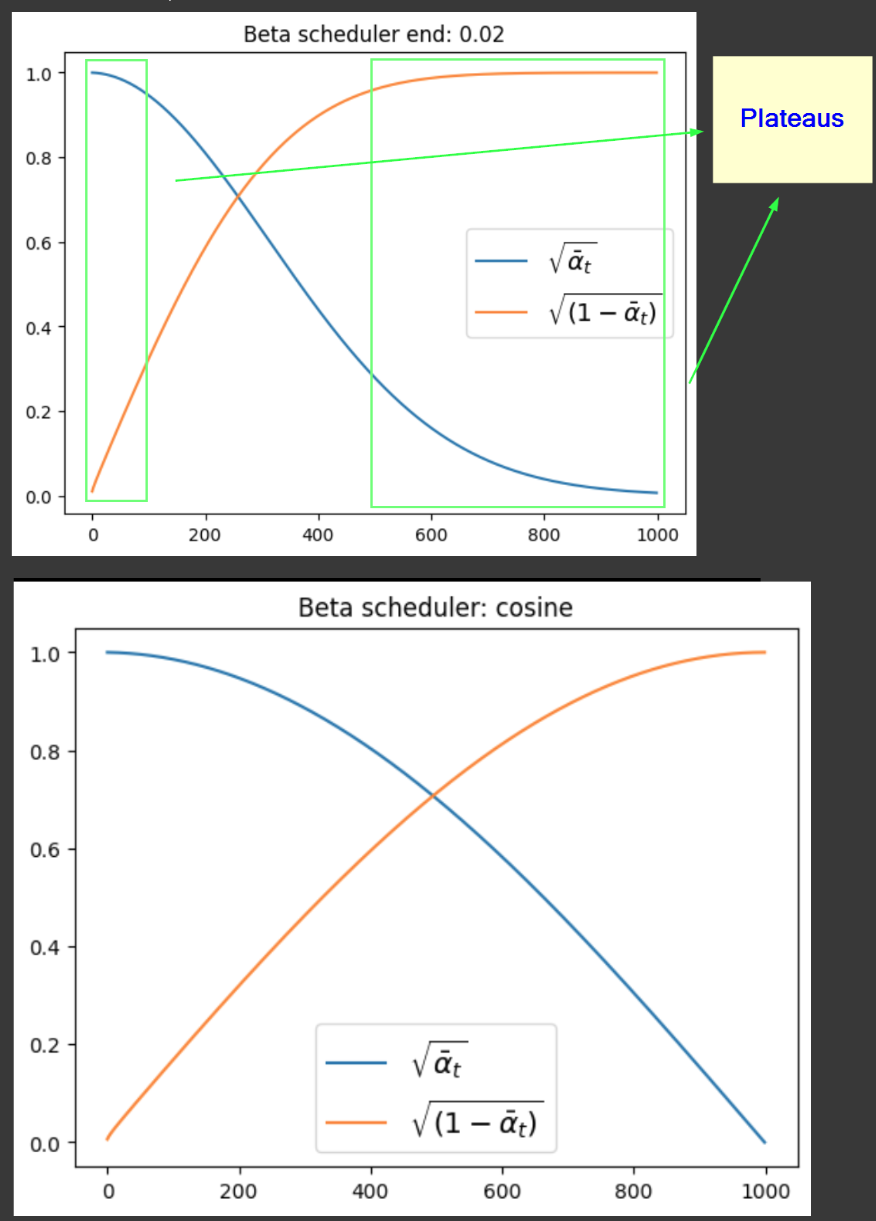



* Regarding the number of timesteps, in the original DDPM [paper](https://arxiv.org/abs/2006.11239) and coommon used value for this hyperparameter is `1000`. However, in the Improved DDPM [paper](https://arxiv.org/pdf/2102.09672), they evidenced that increasing to `4000` the log-likelihood improved (the likelihood that a image generated belongs to the original data images distribution). However, more steps means slower inference.





In [4]:
# Create a scheduler
num_train_timesteps = 1000 # to try: 4000
beta_schedule = 'squaredcos_cap_v2' # cosine for smooth noise scheduling
beta_start = 0.0001 # default from DDPM paper
beta_end = 0.02 # default from DDPM paper

noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps,
                                beta_start=beta_start,
                                beta_end=beta_end,
                                beta_schedule=beta_schedule)

## Training Loop

The training loop consists of:



1.   Loop over epochs
2.   Sample a batch of images from your dataset
3. Sample a value of t uniformly for each image in the batch
4. Sample noise from a Gaussian Distribution with 0 mean and unit variance.
5. Each image is noised to that timestep t, and the model predicts the noise in that image.
6. Use MSE loss between the sampled noise and predicted noise for each image


7. Track the experiments and the evolution of image generation process using wandb

#### Loss
* Regarding the loss, I will use the Mean Square Error (MSE) loss. The reason why I select it, is not only becuase in the majority of code examples they use it, but because in the original DDPM article found to be the useful one, extracted from the ELBO loss (used in VAEs) ([more info](https://learnopencv.com/denoising-diffusion-probabilistic-models/#Training-Objective-&-Loss-Function-Used-In-Denoising-Diffusion-Probabilistic-Models)).

#### Optimizer
* In the "Improved DDPM" [paper](https://arxiv.org/pdf/2102.09672) they use Adam optimizer with a batch size of 128, a learning rate of $10^{-4}$
* I am going to add the OneCycleLR that I have used in other projects with great results, avoiding using the same learning rate in all batches and recommended for fast convergece ([paper](https://arxiv.org/abs/1708.07120)).

In [ ]:
# bs = 5

# # Set the seed for reproducibility
# np.random.seed(42)

# # Number of samples you want in your subset
# num_samples = 10

# # Randomly select indices for the subset
# subset_indices = np.random.choice(len(dataset), num_samples, replace=False)

# # Create the subset
# subset_dataset = Subset(dataset, subset_indices)
# subset_dataloader = DataLoader(subset_dataset, batch_size=bs, shuffle=True)


# # for batch_idx, (images, labels) in enumerate(subset_dataloader):
# #     if batch_idx == 0:
# #         print(f"Batch {batch_idx + 1}")
# #         print(f"Images shape: {images.shape}")
# #         print(f"Labels: {labels}")
# #     if batch_idx == 1:  # Only show the first batch for brevity
# #         break


# # How many runs through the data should we do?
# n_epochs = 1

# # network to train
# net = ClassConditionedUnet().to(device)

# # Mean Square Error loss function
# loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(net.parameters(), lr=1e-4) # The lr optimizer from Improved DDPM paper

# # Keeping a record of the losses
# losses = []
# liveloss = PlotLosses() # plot and update loss plot after each epoch dunring training

# # The training loop
# for epoch in range(n_epochs):
#     for x, y in tqdm(subset_dataloader):
#         logs = {} # for liveloss plot in each epoch

#         # Get some data and prepare the corrupted version
#         x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
#         y = y.to(device)
#         noise = torch.randn_like(x)
#         timesteps = torch.randint(0, num_train_timesteps, (x.shape[0],)).long().to(device)
#         noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

#         # Get the model prediction
#         pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

#         # Calculate the loss
#         loss = loss_fn(pred, noise) # How close is the output to the noise

#         # Backprop and update the params:
#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         # Store the loss for later
#         losses.append(loss.item())


#         logs["MSE loss"] = loss.item()
#         liveloss.update(logs)
#         liveloss.draw()

#     # Print out the average of the last 10% loss values to get an idea of progress:
#     num_elements = math.ceil(len(losses) * 0.1)
#     avg_loss = sum(losses[-num_elements:]) / num_elements

#     print(f'Finished epoch {epoch}. Average of the last {num_elements} loss values (steps): {avg_loss:05f}')

#     # save the noisy scheduler
#     image_pipe = DDPMPipeline(scheduler=noise_scheduler)
#     scheduler_save_path = "/content/drive/MyDrive/Colab Notebooks/Diffuser/Centric-Software/fashion_class_cond_unet_model"
#     image_pipe.save_pretrained(scheduler_save_path)
#     # save the Cond Unet model
#     model_save_path = os.path.join(scheduler_save_path, "fashion_class_cond_unet_model.pth")
#     torch.save(model, model_save_path)

In [11]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def prepare_data_for_training(x, device, noise_scheduler):
    x = x.to(device) * 2 - 1  # Data on the GPU (mapped to (-1, 1))
    noise = torch.randn_like(x)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.shape[0],)).long().to(device)
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
    return noisy_x, noise, timesteps

def train_step(net, loss_fn, opt, scheduler, x, y, device, noise_scheduler):
    # Prepare data
    noisy_x, noise, timesteps = prepare_data_for_training(x, device, noise_scheduler)
    y = y.to(device)

    # Get the model prediction
    pred = net(noisy_x, timesteps, y)  # Note that we pass in the labels y

    # Calculate the loss
    loss = loss_fn(pred, noise)  # How close is the output to the noise

    # Backprop and update the params
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    return loss.item()

def train_one_epoch(net, loss_fn, opt, scheduler, dataloader, device, noise_scheduler, liveloss):
    epoch_losses = []

    for x, y in tqdm(dataloader, desc= "\t Batches"):
        logs = {}  # For liveloss plot in each epoch

        # Perform a training step
        loss = train_step(net, loss_fn, opt, scheduler, x, y, device, noise_scheduler)

        # Store the loss for later
        epoch_losses.append(loss)

        logs["MSE loss"] = loss
        liveloss.update(logs)
        # liveloss.send()

        # Log to wandb
        wandb.log({"loss": loss, "learning_rate": scheduler.get_last_lr()[0]})

    return epoch_losses


def log_images(model, device, img_size, noise_scheduler):
    """
    Log images to wandb and save them to disk.

    Parameters:
    - model: The trained model to use for generating images.
    - device: The device (CPU or GPU) to run the generation on.
    - img_size: The size of the images to generate.
    - noise_scheduler: The noise scheduler used for the generation process.
    """
    sampled_images = sample(model, img_size, noise_scheduler, device)
    wandb.log({"sampled_images": [wandb.Image(img.permute(1, 2, 0).squeeze().cpu().numpy()) for img in sampled_images]})

def sample(model, img_size, noise_scheduler, device):
    """
    Sample images using the trained model.

    Parameters:
    - model: The trained model to use for generating images.
    - img_size: The size of the images to generate.
    - noise_scheduler: The noise scheduler used for the generation process.
    - device: The device (CPU or GPU) to run the generation on.
    """
    model.eval()

    desired_class = [7] # desired class from 0 -> 9
    num_samples = 1  # num of images to generate per class

    # Prepare random x to start from
    x = torch.randn(num_samples*len(desired_class), 1, 28, 28).to(device)
    ic(x.shape)

    # Prepare the desired classes
    y = torch.tensor([[i]*num_samples for i in desired_class]).flatten().to(device)
    ic(y.shape)

    for i, t in tqdm(enumerate(noise_scheduler.timesteps), total=len(noise_scheduler.timesteps),
                     desc="Sampling image", leave = False):
      # Get model pred
      with torch.no_grad():
          residual = model(x, t, y)

      # Update sample with step
      x = noise_scheduler.step(residual, t, x).prev_sample

    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

def train_model(n_epochs, net, loss_fn, opt, scheduler, dataloader, device, noise_scheduler):
    losses = []
    liveloss = PlotLosses()

    for epoch in tqdm(range(n_epochs), desc="Epochs"):
        # Train for one epoch
        epoch_losses = train_one_epoch(net, loss_fn, opt, scheduler, dataloader, device, noise_scheduler, liveloss)
        losses.extend(epoch_losses)

        # Print out the average of the last 10% loss values to get an idea of progress
        num_elements = math.ceil(len(losses) * 0.1)
        avg_loss = sum(losses[-num_elements:]) / num_elements

        print(f'\t ==> Finished epoch {epoch}. Average of the last {num_elements} loss values (steps): {avg_loss:.5f}')
        wandb.log({"epoch": epoch, "avg_loss": avg_loss})

        # Log images at the end of each epoch
        num_classes = 1
        img_size = 28
        log_images(net, device, img_size, noise_scheduler)
        print("\t ==> Images logged to wandb.")




##### TRAINING PARAMETERS

# data for training
bs_train = 32
train_dataloader = DataLoader(dataset, batch_size=bs_train, shuffle=True)
n_epochs = 15

# model and loss function
model = ClassConditionedUnet().to(device)  # model
loss_fn = nn.MSELoss() # loss function

# Adam for Weight optimizaton and OneCycleLR scheduling for learning rate
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=n_epochs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)


# Launch training loop
ic.disable() # disable debug print
with wandb.init(project="GenAI-FashionMNIST", group="train", config=wandb.config):
  wandb.config.n_epochs = n_epochs
  wandb.config.model = model.model.config
  wandb.config.loss_function = "MSE"
  wandb.config.opt = "Adam"
  wandb.config.opt_params = opt.state_dict()['param_groups'][0]
  wandb.config.opt_scheduler = scheduler.state_dict()
  wandb.config.noise_scheduler_config = noise_scheduler.config


  train_model(n_epochs = wandb.config.n_epochs,
              net = model,
              loss_fn = loss_fn,
              opt = opt,
              scheduler = scheduler,
              dataloader= train_dataloader,
              device = device,
              noise_scheduler = noise_scheduler
              )

# save the noisy scheduler
image_pipe = DDPMPipeline(scheduler=noise_scheduler)
scheduler_save_path = "/content/drive/MyDrive/Colab Notebooks/Diffuser/Centric-Software/fashion_class_cond_unet_model"
image_pipe.save_pretrained(scheduler_save_path)
# save the Cond Unet model
model_save_path = os.path.join(scheduler_save_path, "fashion_class_cond_unet_model.pth")
torch.save(model, model_save_path)

wandb: Currently logged in as: huertas_97. Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

	 Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

	 ==> Finished epoch 0. Average of the last 188 loss values (steps): 0.08111


Sampling image:   0%|          | 0/1000 [00:00<?, ?it/s]

	 ==> Images logged to wandb.


	 Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

## Inference

In [ ]:
# load saved model
cond_unet_model_loaded = torch.load(model_save_path)

DEBUG -> x.shape: torch.Size([2, 1, 28, 28])
DEBUG -> y.shape: torch.Size([2])


0it [00:00, ?it/s]

DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])
DEBUG -> t.shape: torch.Size([])


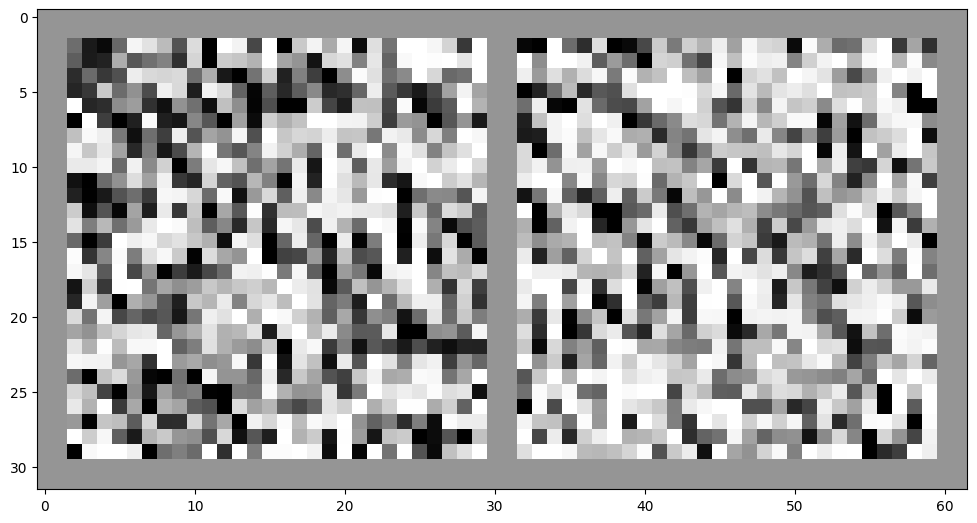

In [52]:
desired_class = [7] # desired class from 0 -> 9
num_samples = 2  # num of images to generate per class

# Prepare random x to start from
x = torch.randn(num_samples*len(desired_class), 1, 28, 28).to(device)
ic(x.shape)

# Prepare the desired classes
y = torch.tensor([[i]*num_samples for i in desired_class]).flatten().to(device)
ic(y.shape)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  ic(t.shape)

  # Get model pred
  with torch.no_grad():
      residual = net(x, t, y)

  # Update sample with step
  x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

## TRain

In [ ]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:


# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-4) # The lr optimizer from Improved DDPM paper
# optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

## FROM PRETRAINED

#### Unconditional Generation

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--ksaml--mnist-fashion_64/snapshots/3635c8bd3bf7ad2a42fa1bc0d1faa0168d6deda4: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--ksaml--mnist-fashion_64/snapshots/3635c8bd3bf7ad2a42fa1bc0d1faa0168d6deda4.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

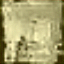

In [26]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('ksaml/mnist-fashion_64')
image = pipeline().images[0]
image


In [87]:
from diffusers import DDPMPipeline

pipeline_2 = DDPMPipeline.from_pretrained('utsavnandi/fashion-mnist-ddpm-32px-5000_steps')
image_2 = pipeline_2().images[0]
image_2


### Class Conditional Generation from unconditional pre-trained UNet

In [88]:
from diffusers import UNet2DModel, DDPMPipeline

model_id = 'google/ddpm-cifar10-32' # ksaml/mnist-fashion_64
pipeline_2 = DDPMPipeline.from_pretrained(model_id)
pipeline_2.unet.config["in_channels"] # 3

# Create 8 images
# images = pipeline_2(batch_size=1).images

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

3

In [106]:
import torch
import torch.nn as nn
from diffusers import DDPMPipeline, UNet2DModel
import torchsummary
from icecream import ic  # Assuming you have `icecream` installed for debug prints

# Load the pre-trained pipeline
model_id = 'google/ddpm-cifar10-32'  # Replace with your model ID
pipeline_2 = DDPMPipeline.from_pretrained(model_id)
pretrained_unet = pipeline_2.unet

# Modify the first and last convolutional layers of the pre-trained UNet to accept a variable number of channels
class ModifiedUNet2DModel(UNet2DModel):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_in = nn.Conv2d(in_channels, self.conv_in.out_channels, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(self.conv_out.in_channels, out_channels, kernel_size=3, padding=1)

# Function to create the modified UNet with selectable number of input and output channels
def create_modified_unet(model_id, in_channels, out_channels):
    # Load the pre-trained pipeline
    pipeline_2 = DDPMPipeline.from_pretrained(model_id)
    pretrained_unet = pipeline_2.unet

    # Create a modified U-Net model based on the pre-trained weights
    pretrained_unet_config = pretrained_unet.config
    modified_unet = ModifiedUNet2DModel(
        in_channels=in_channels,  # Selectable number of input channels
        out_channels=out_channels,  # Selectable number of output channels
        layers_per_block=pretrained_unet_config.layers_per_block,
        block_out_channels=pretrained_unet_config.block_out_channels,
        down_block_types=pretrained_unet_config.down_block_types,
        up_block_types=pretrained_unet_config.up_block_types,
    )

    # Load the pre-trained weights into the modified model, handling the mismatch for conv_in and conv_out manually
    pretrained_state_dict = pretrained_unet.state_dict()

    # Adjust the weights for the first convolutional layer
    conv_in_weight = pretrained_state_dict['conv_in.weight']
    new_conv_in_weight = torch.zeros((conv_in_weight.shape[0], in_channels, *conv_in_weight.shape[2:]))
    new_conv_in_weight[:, :conv_in_weight.shape[1], :, :] = conv_in_weight

    # Adjust the weights for the last convolutional layer
    conv_out_weight = pretrained_state_dict['conv_out.weight']
    new_conv_out_weight = torch.zeros((out_channels, conv_out_weight.shape[1], *conv_out_weight.shape[2:]))
    new_conv_out_weight[:conv_out_weight.shape[0], :, :, :] = conv_out_weight

    # Update the state dict with the new weights for conv_in and conv_out
    pretrained_state_dict['conv_in.weight'] = new_conv_in_weight
    pretrained_state_dict['conv_out.weight'] = new_conv_out_weight

    # Load the state dict into the modified model
    modified_unet.load_state_dict(pretrained_state_dict, strict=False, )

    return modified_unet

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4, in_channels=5, out_channels=5):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is the modified pre-trained UNet
        self.model = create_modified_unet(model_id, in_channels, out_channels)

    # Forward method takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape  # x is shape (bs, 1, 28, 28)
        ic(x.shape)  # DEBUG -> x.shape: torch.Size([4, 1, 28, 28])

        # Class conditioning embedding to add as additional input channels
        class_cond = self.class_emb(class_labels)  # Map to embedding dimension
        ic(class_cond.shape)  # DEBUG -> class_cond.shape: torch.Size([4, 4])
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # Class_cond final shape (bs, 4, 28, 28)
        ic(class_cond.shape)

        # Model input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, in_channels, 28, 28)
        ic(net_input.shape)

        # Feed this to the UNet alongside the timestep and return the prediction
        output = self.model(net_input, t).sample  # (bs, out_channels, 28, 28)
        ic(output.shape)
        return output

# Instantiate the model with a selectable number of input and output channels
num_input_channels = 5  # Example: 5 input channels (1 for image + 4 for class embedding)
num_output_channels = 5  # Example: 5 output channels (to match input channels)
model_from_pretrained_unet = ClassConditionedUnet(num_classes=10, class_emb_size=4, in_channels=num_input_channels, out_channels=num_output_channels)

# Dummy input for forward pass for torchsummary to estimate size
x = torch.randn(4, 1, 28, 28)     # Dummy input for image
t = torch.tensor([0.5])           # Dummy timestep
class_labels = torch.tensor([0, 1, 2, 3])  # Dummy class labels matching batch size
dummy_input = (x, t, class_labels)

# Model summary (condensed view)
_ = torchsummary.summary(model_from_pretrained_unet,
                         device='cpu')

# Model summary (expanded view with forward pass)
print(f"\n\n{'-'*50} \n\n")
_ = torchsummary.summary(model_from_pretrained_unet,
                         input_data=dummy_input,
                         device='cpu')


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Error(s) in loading state_dict for ModifiedUNet2DModel:
	size mismatch for conv_out.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([5]).

In [93]:
# Create a scheduler
num_train_timesteps = 10 # to try 4000
beta_schedule = 'squaredcos_cap_v2' # cosine for smooth noise scheduling
beta_start = 0.0001 # default from DDPM paper
beta_end = 0.02 # default from DDPM paper

noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps,
                                beta_start=beta_start,
                                beta_end=beta_end,
                                beta_schedule=beta_schedule)

In [94]:
# How many runs through the data should we do?
n_epochs = 10


# Mean Square Error loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-4) # The lr optimizer from Improved DDPM paper

# Keeping a record of the losses
losses = []
liveloss = PlotLosses() # plot and update loss plot after each epoch dunring training

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(subset_dataloader):
        logs = {} # for liveloss plot in each epoch

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, num_train_timesteps, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = model_from_pretrained_unet(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())


        logs["loss"] = loss.item()
        liveloss.update(logs)
        liveloss.draw()

    # Print out the average of the last 10% loss values to get an idea of progress:
    num_elements = math.ceil(len(losses) * 0.1)
    avg_loss = sum(losses[-num_elements:]) / num_elements

    print(f'Finished epoch {epoch}. Average of the last {num_elements} loss values (steps): {avg_loss:05f}')


  0%|          | 0/2 [00:00<?, ?it/s]

net_input shape: torch.Size([5, 5, 28, 28])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 7 for tensor number 1 in the list.

In [ ]:
desired_class = [7] # desired class from 0 -> 9
num_samples = 2  # num of images to generate per class

# Prepare random x to start from
x = torch.randn(num_samples*len(desired_class), 1, 28, 28).to(device)
ic(x.shape)

# Prepare the desired classes
y = torch.tensor([[i]*num_samples for i in desired_class]).flatten().to(device)
ic(y.shape)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  ic(t.shape)

  # Get model pred
  with torch.no_grad():
      residual = model_from_pretrained_unet(x, t, y)

  # Update sample with step
  x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

In [124]:
from diffusers import UNet2DConditionModel

model_id = "runwayml/stable-diffusion-v1-5"
unet = UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
    in_channels=9,
    low_cpu_mem_usage=False,
    ignore_mismatched_sizes=True,
    use_safetensors=True,
)

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Some weights of UNet2DConditionModel were not initialized from the model checkpoint at runwayml/stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 9, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [123]:
from diffusers import UNet2DModel, UNet2DConditionModel

model_id = 'google/ddpm-cifar10-32' # ksaml/mnist-fashion_64
pipeline_2 = DDPMPipeline.from_pretrained(model_id)
pipeline_2.unet.config["in_channels"] # 3

pretrained_unet = UNet2DConditionModel.from_pretrained(
    model_id,
    # subfolder="unet",
    in_channels=5, # check this
    # out_channels=5,
    low_cpu_mem_usage=False, # avoid a size mismatch error because the shape is different now
    ignore_mismatched_sizes=True, # avoid a size mismatch error because the shape is different now
    use_safetensors=True,
)


class ClassConditionedUnet_MODEL(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is the modified pre-trained UNet
        self.model = pretrained_unet

    # Forward method takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape  # x is shape (bs, 1, 28, 28)
        ic(x.shape)  # DEBUG -> x.shape: torch.Size([4, 1, 28, 28])

        # Class conditioning embedding to add as additional input channels
        class_cond = self.class_emb(class_labels)  # Map to embedding dimension
        ic(class_cond.shape)  # DEBUG -> class_cond.shape: torch.Size([4, 4])
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # Class_cond final shape (bs, 4, 28, 28)
        ic(class_cond.shape)

        # Model input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, in_channels, 28, 28)
        ic(net_input.shape)

        # Feed this to the UNet alongside the timestep and return the prediction
        output = self.model(net_input, t).sample  # (bs, out_channels, 28, 28)
        ic(output.shape)
        return output

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: object of type 'NoneType' has no len()

In [116]:
pretrained_unet.state_dict()['conv_out.weight'].shape

torch.Size([5, 128, 3, 3])

In [114]:
pretrained_unet

UNet2DModel(
  (conv_in): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [122]:
model

ClassConditionedUnet_MODEL(
  (class_emb): Embedding(10, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=128, out_features=512, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()

In [121]:
model = ClassConditionedUnet_MODEL()

# Dummy input for forward pass for torchsummary to estimate size
x = torch.randn(1, 1, 28, 28)     # Dummy input for image
t = torch.tensor([0.5])           # Dummy timestep
class_labels = torch.tensor([0])  # Dummy class label
dummy_input = (x, t, class_labels)

# model summary (condensed view)
_ = torchsummary.summary(model,
                        #  input_data=dummy_input,
                         device='cpu')

# model summary (expanded view with forward pass)
print(f"\n\n{'-'*50} \n\n")
_ = torchsummary.summary(model,
                         input_data=dummy_input,
                         device='cpu', )

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         40
├─UNet2DModel: 1-2                       --
|    └─Conv2d: 2-1                       5,888
|    └─Timesteps: 2-2                    --
|    └─TimestepEmbedding: 2-3            --
|    |    └─Linear: 3-1                  66,048
|    |    └─SiLU: 3-2                    --
|    |    └─Linear: 3-3                  262,656
|    └─ModuleList: 2-4                   --
|    |    └─DownBlock2D: 3-4             870,272
|    |    └─AttnDownBlock2D: 3-5         3,480,320
|    |    └─DownBlock2D: 3-6             3,215,104
|    |    └─DownBlock2D: 3-7             2,625,024
|    └─ModuleList: 2-5                   --
|    |    └─UpBlock2D: 3-8               6,692,608
|    |    └─UpBlock2D: 3-9               6,692,608
|    |    └─AttnUpBlock2D: 3-10          7,155,712
|    |    └─UpBlock2D: 3-11              1,789,952
|    └─UNetMidBlock2D: 2-6               --
|    |    └─ModuleList: 3-12             263,680


DEBUG -> x.shape: torch.Size([1, 1, 28, 28])
DEBUG -> class_cond.shape: torch.Size([1, 4])
DEBUG -> class_cond.shape: torch.Size([1, 4, 28, 28])
DEBUG -> net_input.shape: torch.Size([1, 5, 28, 28])


RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: [Embedding: 1-1, Timesteps: 2-1, TimestepEmbedding: 2-2, Linear: 3-1, SiLU: 3-2, Linear: 3-3, Conv2d: 2-3, DownBlock2D: 3-4, SiLU: 3-5, SiLU: 3-6, SiLU: 3-7, SiLU: 3-8, SiLU: 3-9, SiLU: 3-10, AttnDownBlock2D: 3-11, SiLU: 3-12, SiLU: 3-13, SiLU: 3-14, SiLU: 3-15, SiLU: 3-16, SiLU: 3-17, DownBlock2D: 3-18, SiLU: 3-19, SiLU: 3-20, SiLU: 3-21, SiLU: 3-22, SiLU: 3-23, SiLU: 3-24, DownBlock2D: 3-25, SiLU: 3-26, SiLU: 3-27, SiLU: 3-28, SiLU: 3-29, SiLU: 3-30, SiLU: 3-31, UNetMidBlock2D: 2-4, ResnetBlock2D: 4-1, SiLU: 3-32, SiLU: 3-33, SiLU: 3-34, Attention: 4-2, ResnetBlock2D: 4-3, SiLU: 3-35, SiLU: 3-36, SiLU: 3-37, UpBlock2D: 3-38, SiLU: 3-39, SiLU: 3-40, SiLU: 3-41, SiLU: 3-42, SiLU: 3-43, SiLU: 3-44, SiLU: 3-45, SiLU: 3-46, SiLU: 3-47]

## TODO - Continue researching

- As interestingly [paper](https://arxiv.org/abs/2312.09608) suggests that the UNet's encoder (downsampling part) remains largely unexplored.  It mentions that while the encoder features change gradually, the decoder features exhibit significant variations across different time-steps.
So, it opens the door to play with the encoder. One potential approach is to omit the encoder at certain adjacent time-steps and cyclically reuse encoder features from previous time-steps in the decoder. This could reduce computational overhead and speed up the image generation process during inference.

- The previous point, suggests to me that playing with the feature in the latent space before passing them to the decoder could be quite interesting. Experimenting with different transformations or augmentations of these latent features could potentially enhance the model's performance and the quality of generated images. Or even trying to apply techniques to generate higher resolution outputs than the inputs (quite challenging but useful becuase 28x28 px images are not handy for hummans).

- It is true that, in the original paper of DDPM, the authors show how the model just needs to predict the noise at each time step. So the authors show that it can be simply but effectively reduced to the Mean Square Error (MSE) between the noise added in the forward process and the noise predicted by the model. Nevertheless, I think we explore other losses.

 - For example, it seems to me quite clear that Kullback-Leiber (KL) Divergence is a suitable choice. It is used in other techniques (e.g., T-SNE), and it is quite useful in this scenario since, as an overview, KL Divergnce measures the difference between two probability distribution. In this diffusion problem, it would be the distribution predicted by the model and the expected distribution of the noise applied. This relates closely with the initial point about the encoder, because this loss would require that the encoder's latent space embeddings adheres to a probabilistic distribution. This, at my point of view have benefits like robustness & generalization, certainty in the model's predictions & interpretability.

 - Other metrics like the Frechet Inception Distance (FID) score, that has been applied to GANs and measure the similarity between a generated image and a real one.

- It is a no brainer: explore different noise schedulers. A really nice explanation, with cons and pros of a broad variety of schedulers can be found in Stable Diffusion [blog](https://stable-diffusion-art.com/samplers/).

- For sake of practicality, I have used the blocks provided by Diffusers, which are more handy but less configurable. I mention that, becuase we could:
   * Explore the use of Rotary Position Embedding ([ROPE](https://arxiv.org/abs/2104.09864)) technique for possitional encoding, instead of the sinusoidal position embeddings (`SiLU` in the torchsummary) for the timestep positional embeddings. In short, ROPE combines absolute and relative position so can help the model to better understandt the noise level at each timestep (absolute position) with a sense of the surrounding noise timesteps (relative position). The straightfoward implication will be in faster convergence during training, but perhaps could lead also to better results or faster inference as we can skip some denoising timesteps. Even though I have not completely read it, it similar to the idea tested in this [article](https://arxiv.org/html/2310.03337v3) about "time-step awareness".


- Instead of using the `UNet2DModel` and uses the class as an extra channel in the input, we could explore `UNet2DConditionModel` that requires texts alongside the noise input. So the class could be passed as a text string, or using a text-to-image approach.


Reading the [documentation](https://huggingface.co/docs/diffusers/api/models/unet2d), the Class conditioning is supported in the UNetModel class from Diffusers  [link](https://discuss.huggingface.co/t/add-additional-conditioning-info/30195/20).

So we can try this already implemented version for a cleaner implementation version of the model that will be also easier to load as a pipeline and integrated in the Diffuser library.

In [59]:
from diffusers import UNet2DModel

# Number of classes for conditioning
num_classes = 10

# Configure the UNet2DModel with class conditioning
model_classcond_native = UNet2DModel(
    sample_size=28,           # output image resolution. Equal to input resolution
    in_channels=1,            # Input channels for the image
    out_channels=1,           # the number of output channels. Equal to input
    layers_per_block=2,       # Two residual connections (ResNet) per block
    block_out_channels=(224, 448, 672), # Number of output channels for each block. Adjusted for higher capacity
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
    ),
    dropout=0.1,              # Dropout probability between Conv1 and Conv2 in a block. From Improved DDPM paper
    act_fn='silu',            # Activation function
    attention_head_dim=8,     # Attention head dimension
    norm_num_groups=32,       # Group normalization
    resnet_time_scale_shift='default',  # Time embedding scaling
    add_attention=True,       # Adding attention layers
    class_embed_type=None,  # Type of class embedding to use
    num_class_embeds=num_classes,  # Number of classes for embedding
).to(device)

# Dummy input for forward pass for torchsummary to estimate size
x = torch.randn(1, 1, 28, 28).to(device)  # Dummy input for image
t = torch.tensor([0.5]).to(device)  # Dummy timestep
class_labels = torch.tensor([0]).to(device)  # Dummy class label
dummy_input = (x, t, class_labels)

# Model summary (condensed view)
_ = torchsummary.summary(model_classcond_native,
                         input_data=dummy_input,
                         device=device)


Layer (type:depth-idx)                        Output Shape              Param #
├─Timesteps: 1-1                              [-1, 224]                 --
├─TimestepEmbedding: 1-2                      [-1, 896]                 --
|    └─Linear: 2-1                            [-1, 896]                 201,600
|    └─SiLU: 2-2                              [-1, 896]                 --
|    └─Linear: 2-3                            [-1, 896]                 803,712
├─Embedding: 1-3                              [-1, 896]                 8,960
├─Conv2d: 1-4                                 [-1, 224, 28, 28]         2,240
├─ModuleList: 1                               []                        --
|    └─DownBlock2D: 2-4                       [-1, 224, 14, 14]         --
├─TimestepEmbedding: 1                        []                        --
|    └─SiLU: 2-5                              [-1, 224, 28, 28]         --
|    └─SiLU: 2-6                              [-1, 896]                 --
|   

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

print("Input shape: ", x.shape) # Input shape:  torch.Size([8, 1, 28, 28])
print("Labels: ", y.shape) # Labels:  torch.Size([8])

y = y.flatten()
print("Output shape:", model_classcond_native(x, timestep = 0, class_labels = y).sample.shape)

x = torch.randn(1, 1, 28, 28).to(device)  # Dummy input for image
t = torch.tensor([0.5]).to(device)  # Dummy timestep
class_labels = torch.tensor([0]).to(device)  # Dummy class label

print("Output shape:", model_classcond_native(x, timestep = t, class_labels = class_labels).sample.shape)